# Task 4: Predictive Modeling


## 1. Load and Prepare Data

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
import shap

# Load data
df = pd.read_csv("../data/insurance.txt", delimiter="|")

# Add target for binary classification
df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)


/tmp/ipykernel_249342/174730712.py:11: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/insurance.txt", delimiter="|")


## 2. Feature Engineering and Encoding

In [19]:
features = [
    'Province', 'PostalCode', 'VehicleType', 'RegistrationYear',
    'make', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype',
    'CustomValueEstimate', 'Gender', 'NumberOfVehiclesInFleet'
]

targets = ['TotalClaims', 'CalculatedPremiumPerTerm', 'ClaimOccurred']
all_cols = features + targets

# Drop columns with more than 50% null values
valid_columns = df[all_cols].loc[:, df[all_cols].isnull().mean() < 0.5].columns
df = df[valid_columns].dropna()
print(f"Final shape: {df.shape}")


Final shape: (990010, 13)


In [20]:
# Encode remaining categorical variables
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


## 3. Claim Severity Prediction (XGBoost Regressor)

In [23]:
features = [col for col in df.columns if col not in targets]
X = df[features]
y = df['TotalClaims']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


RMSE: 2485.5917329104104
R²: -0.0019104552098032634


## 4. Premium Optimization (Random Forest Regressor)

In [24]:
y_premium = df['CalculatedPremiumPerTerm']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_premium, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train_p, y_train_p)
y_p_pred = rf_model.predict(X_test_p)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test_p, y_p_pred))


RMSE: 2485.5917329104104
R²: 0.01374559920296603


## 5. Claim Occurrence Classification (XGBoost Classifier)

In [25]:
y_occurrence = df['ClaimOccurred']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_occurrence, test_size=0.2, random_state=42)

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train_c, y_train_c)
y_pred_c = xgb_classifier.predict(X_test_c)

print(classification_report(y_test_c, y_pred_c))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    197484
           1       0.00      0.00      0.00       518

    accuracy                           1.00    198002
   macro avg       0.50      0.50      0.50    198002
weighted avg       0.99      1.00      1.00    198002



/home/ruhama/Desktop/End-to-End Insurance Risk Analytics & Predictive Modeling/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruhama/Desktop/End-to-End Insurance Risk Analytics & Predictive Modeling/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ruhama/Desktop/End-to-End Insurance Risk Analytics & Predictive Modeling/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and be

## 6. SHAP Interpretability

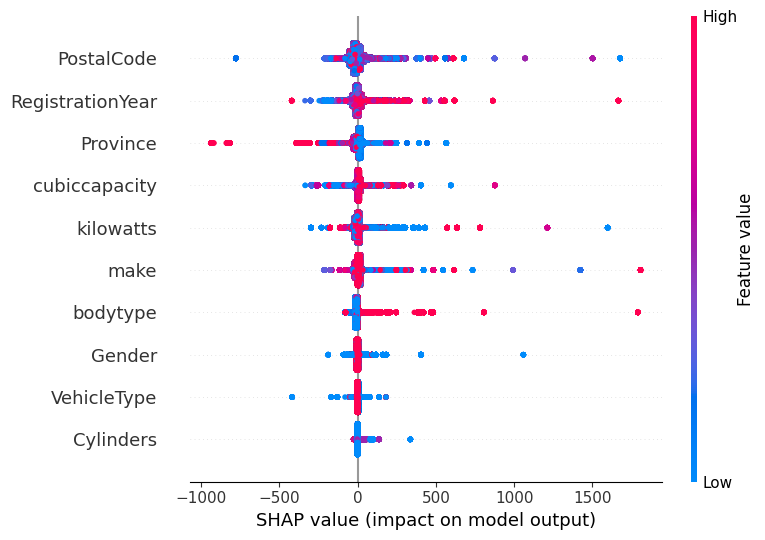

In [26]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)


In [28]:
import os
import matplotlib.pyplot as plt

os.makedirs("../plots", exist_ok=True)

# Save SHAP summary plot
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig("../plots/shap_summary_plot.png", bbox_inches="tight")
plt.close()
